We want to use a UNet model, our images are of size 768x768.
It would be ideal if our output mask would be 256x256 because 768/3 = 256, so
by using this output size we can divide our image into 3x3 squares. 

In our training phase we want to show as many ships as we can to our model,
so it can learn the different variations of them. In order to achive this
we will crop out a ship from an image. In the test and validation sets we will
not use this technique, we are going to go through our images normally.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Here we have each segmentation for a ship
imgs_dir = Path('data/processed/train/')
ship_segmentations = pd.read_csv('data/processed/train_ship_segmentations.csv')
ship_segmentations['EncodedPixels'] = ship_segmentations['EncodedPixels'].fillna('')
ship_segmentations.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
# Here we grouped the images, so EncodedPixels contains all ship segmentations on that image
seg_by_img = ship_segmentations.groupby('ImageId').aggregate({ 'EncodedPixels': ' '.join })
seg_by_img.head()

,EncodedPixels
ImageId,
00003e153.jpg,
0001124c7.jpg,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg,


In [4]:
# Function to decode run length encoding of image segmentation
def decode_rle(rle: str, img_size: tuple[int,int]) -> np.ndarray:
    """Decodes run length encoding into a mask that is the size of img_size.
    
    Args:
        rle (str): The run length encoding
        img_size (tuple[int, int]): The size of the original image (width, height)
    """
    rle = rle.split()
    starts, lengths = [np.asarray(x, dtype=int)
                        for x in (rle[0:][::2], rle[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(img_size[0]*img_size[1], dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    mask = mask.reshape((img_size[1], img_size[0]))
    return mask.transpose()

In [5]:
def bbox(mask: np.ndarray):
    """Returns the bounding box of the mask."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

In [6]:
# First lets collect some data about the size of ships
widths = []
heights = []
for rle in ship_segmentations['EncodedPixels']:
    if rle != '':
        ship_mask = decode_rle(rle, (768, 768))
        ymin, ymax, xmin, xmax = bbox(ship_mask)
        widths.append(xmax-xmin)
        heights.append(ymax-ymin)
    else:
        widths.append(0)
        heights.append(0)
ship_segmentations['width'] = widths
ship_segmentations['height'] = heights

In [7]:
# See how do ship sizes compare to image sizes, 
# as you can see they are a lot smaller
ship_segmentations.describe()

,width,height
count,88997.000000,88997.000000
mean,42.454218,34.476409
std,55.386969,44.288797
min,0.000000,0.000000
25%,8.000000,7.000000
50%,20.000000,18.000000
75%,58.000000,46.000000
max,443.000000,334.000000


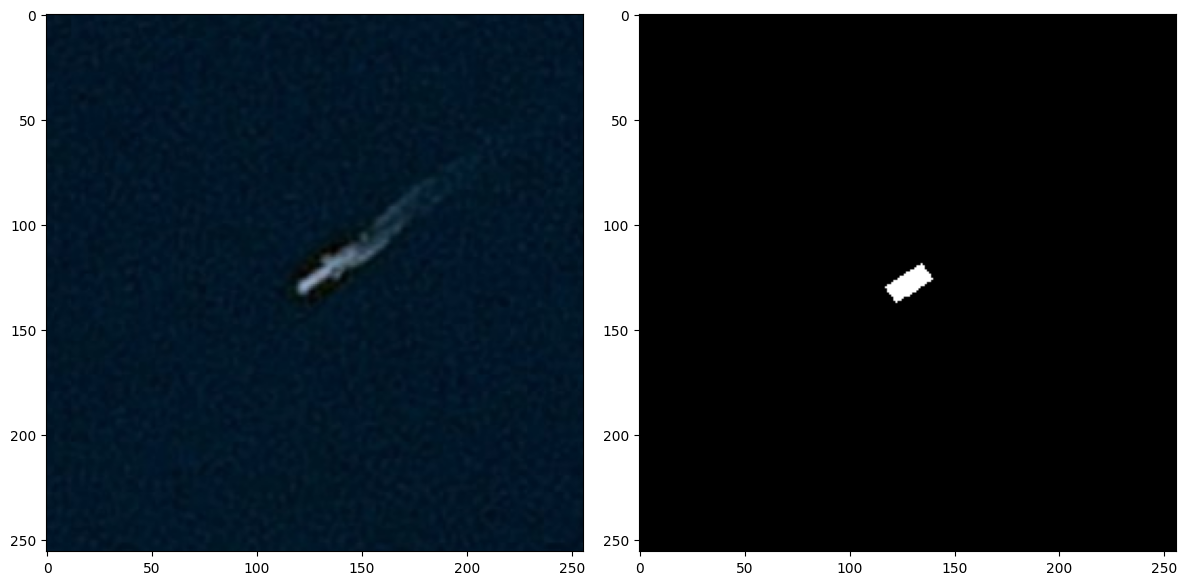

In [8]:
# Get relevant part of image
index = 22 # The index of the image in the dataset

img_id, rle = ship_segmentations.loc[index, ['ImageId', 'EncodedPixels']].tolist()
if rle == '':
    print('Image does not contain any ships')

img = Image.open(imgs_dir / img_id)

ship_mask = decode_rle(rle, (img.width, img.height))
ymin, ymax, xmin, xmax = bbox(ship_mask)
bheight, bwidth = ymax-ymin, xmax-xmin
if bheight < 256:
    ymin = max(0, ymin - (256 - bheight)//2)
    ymax = min(img.height, ymax + (256 - bheight)//2)
if bwidth < 256:
    xmin = max(0, xmin - (256 - bwidth)//2)
    xmax = min(img.width, xmax + (256 - bwidth)//2)

mask = decode_rle(seg_by_img.loc[img_id, 'EncodedPixels'], (img.width, img.height))
mask = Image.fromarray(mask)

mask = mask.crop(((xmin, ymin, xmax, ymax))).resize((256, 256))
img = img.crop((xmin, ymin, xmax, ymax)).resize((256, 256))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.tight_layout()